In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tint.datasets import Arma

arma = Arma()
arma.download()  # This method generates the dataset


/home/paulius/projects/fact/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inputs = arma.preprocess()["x"]
true_saliencies = arma.true_saliency(dim=1)

In [3]:
inputs.size()

torch.Size([1000, 50, 50])

In [4]:
# Taken from https://github.com/fzi-forschungszentrum-informatik/TSInterpret/blob/main/TSInterpret/InterpretabilityModels/Saliency/Saliency_Base.py
def plot_saliency(ts_data, saliency_list, figsize=None):
    if figsize is None:
        figsize = (10, len(ts_data))
    ax011 = []
    i = 0

    fig, axn = plt.subplots(
        len(ts_data), 1, sharex=True, sharey=True, figsize=figsize
    )
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    for channel in ts_data:
        # print(ts_data.shape)
        # ax011.append(plt.subplot(len(ts_data[0]),1,i+1))
        # ax012.append(ax011[i].twinx())
        # ax011[i].set_facecolor("#440154FF")
        axn012 = axn[i].twinx()

        sns.heatmap(
            saliency_list[i].reshape(1, -1),
            fmt="g",
            cmap="viridis",
            cbar=i == 0,
            cbar_ax=None if i else cbar_ax,
            ax=axn[i],
            yticklabels=False,
            vmin=0,
            vmax=1,
        )
        sns.lineplot(
            x=range(0, len(channel.reshape(-1))),
            y=channel.flatten(),
            ax=axn012,
            color="white",
        )
        plt.xlabel("Time", fontweight="bold", fontsize="large")
        plt.ylabel(f"Feature {i}", fontweight="bold", fontsize="large")
        i = i + 1
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

In [70]:
# Taken from https://github.com/fzi-forschungszentrum-informatik/TSInterpret/blob/main/TSInterpret/InterpretabilityModels/Saliency/Saliency_Base.py
def plot_saliency2(saliencies, figsize=None):
    N = len(saliencies)
    if figsize is None:
        figsize = (10, N * 2)

    fig, axn = plt.subplots(
        int(np.ceil(N / 2)), 2, sharex=True, sharey=True, figsize=figsize
    )
    axn = axn.flatten()
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    color_map = sns.diverging_palette(10, 133, as_cmap=True)

    for idx, (method, saliency) in enumerate(saliencies.items()):
        sns.heatmap(
            saliency,
            cmap=color_map,
            cbar=idx == 0,
            cbar_ax=None if idx else cbar_ax,
            cbar_kws={"label": "Mask"},
            ax=axn[idx],
            yticklabels=False,
            linecolor="#d8cbd5",
            linewidths=0.4,
            vmin=0,
            vmax=1,
        )
        axn[idx].set_title(f"Method: {method}")
        axn[idx].set_xlabel("Time")
        axn[idx].set_ylabel("Feature number")
        
    fig.suptitle("Mask coefficients over time")
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

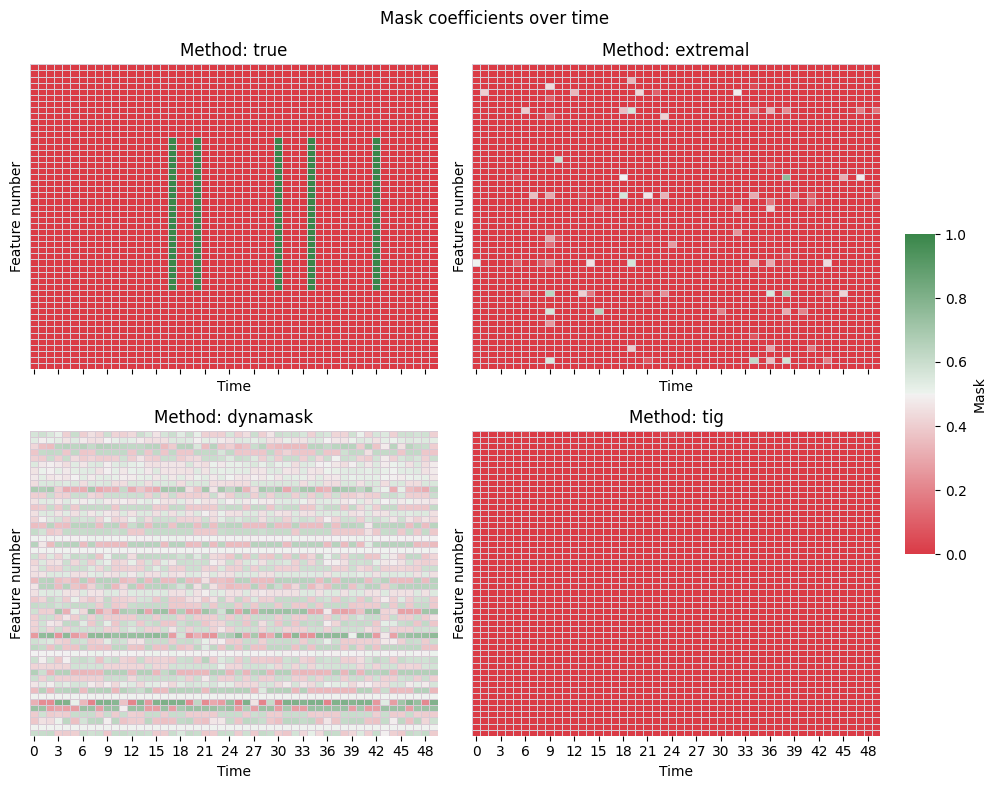

In [71]:
SAL_ID = 0
saliencies = {
    "true": true_saliencies[SAL_ID],
    "extremal": attr_extremal[SAL_ID],
    "dynamask": attr_dynamask[SAL_ID],
    "tig": attr_tig[SAL_ID]
}
plot_saliency2(saliencies)

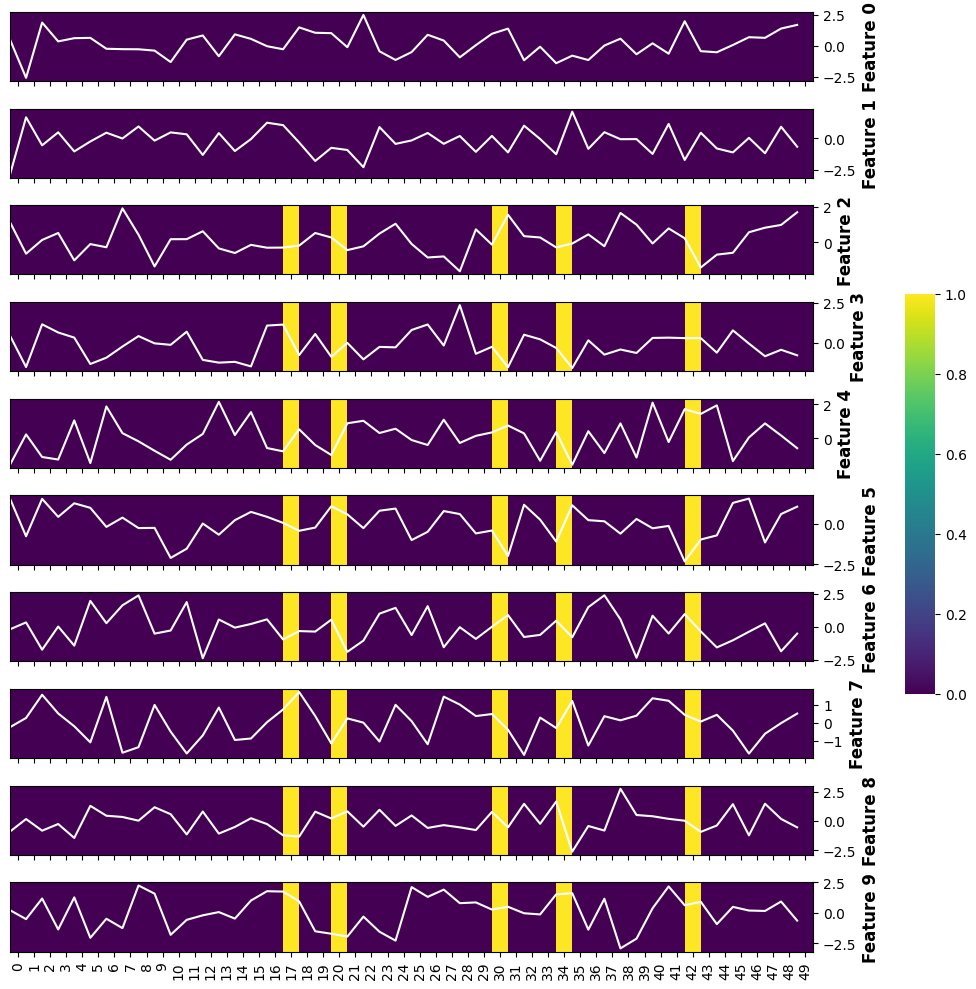

In [73]:
plot_saliency(inputs[0][10:20], true_saliencies[0][10:20])

## Extremal Mask

In [28]:
import torch
from tint.attr import ExtremalMask
from tint.models import MLP

# Init prediction model
mlp = MLP([inputs.size()[2], 3, 1])

# Init explainability models
extremal_explainer = ExtremalMask(mlp)

In [39]:
import pickle

def save_explainer(explainer, mlp, explainer_name="explainer"):
    with open(f"mlp_{explainer_name}.pkl", "wb") as f:
        pickle.dump(mlp, f)

    with open(f"{explainer_name}.pkl", "wb") as f:
        pickle.dump(explainer, f)


def load_explainer(explainer_name="explainer"):
    with open(f"mlp_{explainer_name}.pkl", "rb") as f:
        mlp = pickle.load(f)

    with open(f"{explainer_name}.pkl", "rb") as f:
        explainer = pickle.load(f)       

    return mlp, explainer

In [29]:
# Fit explainer on inputs given the MLP
attr_extremal = extremal_explainer.attribute(inputs)
save_explainer(attr_extremal, mlp, explainer_name="extremal")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-01-14 23:41:27.853133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 23:41:27.853177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 23:41:27.858390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 23:41:27.877324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

Epoch 99: 100%|██████████| 32/32 [00:01<00:00, 22.47it/s, v_num=10]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:01<00:00, 21.04it/s, v_num=10]


In [33]:
print(f"AUP: {aup(attr_extremal, true_saliencies):.4}")
print(f"AUR: {aur(attr_extremal, true_saliencies):.4}")
print(f"RMSE: {rmse(attr_extremal, true_saliencies):.4}")

AUP: 0.06901
AUR: 0.0211
RMSE: 0.2393


In [ ]:
plot_saliency(inputs[0], attr_extremal[0])

## Dynamic Mask

In [43]:
import torch
from tint.attr import DynaMask
from tint.models import MLP

# Init prediction model
mlp = MLP([inputs.size()[2], 3, 1])

# Init explainability models
dynamask_explainer = DynaMask(mlp)

In [44]:
attr_dynamask = dynamask_explainer.attribute(inputs)
save_explainer(attr_dynamask, mlp, explainer_name="dynamask")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | net   | Mask    | 2.5 M 
1 | _loss | MSELoss | 0     
----------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.000    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s] 

Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 34.86it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 32/32 [00:00<00:00, 133.87it/s]


In [45]:
print(f"AUP: {aup(attr_dynamask, true_saliencies):.4}")
print(f"AUR: {aur(attr_dynamask, true_saliencies):.4}")
print(f"RMSE: {rmse(attr_dynamask, true_saliencies):.4}")

AUP: 0.05043
AUR: 0.5163
RMSE: 0.5525


In [ ]:
plot_saliency(inputs[0], attr_dynamask[0])

## Temporal Integrated Gradient

In [63]:
import torch
from tint.attr import TemporalIntegratedGradients
from tint.models import MLP

# Init prediction model
mlp = MLP([inputs.size()[2], 3, 1])

# Init explainability models
tig_explainer = TemporalIntegratedGradients(mlp)

In [64]:
attr_tig = tig_explainer.attribute(inputs, target=0)
save_explainer(attr_tig, mlp, explainer_name="tig")

In [65]:
print(f"AUP: {aup(attr_tig, true_saliencies):.4}")
print(f"AUR: {aur(attr_tig, true_saliencies):.4}")
print(f"RMSE: {rmse(attr_tig, true_saliencies):.4}")

AUP: 0.03785
AUR: 0.4999
RMSE: 0.5123


In [ ]:
plot_saliency(inputs[0], attr_tig[0])